## Import

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# Set seaborn style for professional plots
sns.set_style("darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
sns.set_palette("husl")  # Set color palette

## DJIA_table.csv

In [2]:
data = pd.read_csv('../data/raw/DJIA_table.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# CLEAN: forcer colonnes numériques (gère virgules, espaces, chaînes)
num_cols = ['Open','High','Low','Close','Adj Close','Volume']
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].astype(str).str.replace(r'[,\\s]', '', regex=True),
                                errors='coerce')

data.columns = data.columns.str.strip()
num_cols = ['Open','High','Low','Close','Adj Close','Volume']
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].astype(str).str.replace(r'[,\\s]', '', regex=True),
                                errors='coerce')

# garantir colonne ajustée utilisable (fallback sur Close)
adj_candidates = ['Adj Close', 'Adj_Close', 'AdjClose', 'Adjusted Close']
adj_col = next((c for c in adj_candidates if c in data.columns), None)
if adj_col is None:
    if 'Close' in data.columns:
        data['Adj Close'] = data['Close'].copy()
        adj_col = 'Adj Close'

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1989 non-null   datetime64[ns]
 1   Open       1989 non-null   float64       
 2   High       1989 non-null   float64       
 3   Low        1989 non-null   float64       
 4   Close      1989 non-null   float64       
 5   Volume     1989 non-null   int64         
 6   Adj Close  1989 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 108.9 KB


In [4]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


### some plots

In [5]:
def plot_price(data, window=None, x_ticks=True, col="Adj Close", ax=None):
    # Create figure only if no axis is provided
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    # Make background transparent
    ax.patch.set_alpha(0.7)  # Fully transparent axes background

    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]

    # Top plot: Closing Price
    ax.plot(data['Date'], data[col], label=f'{col}', 
            color='#2E86AB', linewidth=1.5, alpha=0.9)

    # Styling for price plot
    ax.set_ylabel(f'{col}', fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--')
    ax.legend(framealpha=0.9)

    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # Remove x-axis ticks if specified
    if not x_ticks:
        ax.set(xticklabels=[])
    else:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right') 
        
    return ax

Text(0.5, 1.0, 'DJIA Trading Time Series')

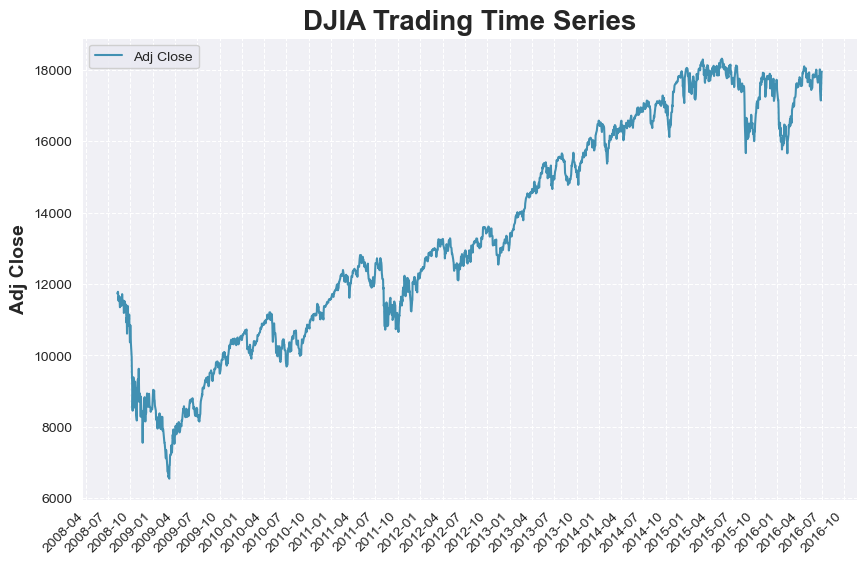

In [6]:
window = None
ax = plot_price(data, window)
plt.title("DJIA Trading Time Series", fontsize=20, fontweight='bold')




In [7]:
def plot_volume(data, window=None):
    _, ax = plt.subplots(figsize=(10, 6))
    red, green = '#DC3545', '#28A745'
    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]
    
    colors = [green if data.loc[i, 'Adj Close'] >= data.loc[i, 'Open'] 
            else red for i in range(len(data))]
    ax.bar(data['Date'], data['Volume'], color=colors, alpha=0.6, width=1)
    ax.set_ylabel('Volume', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Format x-axis dates for volume plot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


# plt.tight_layout()
# plt.show()


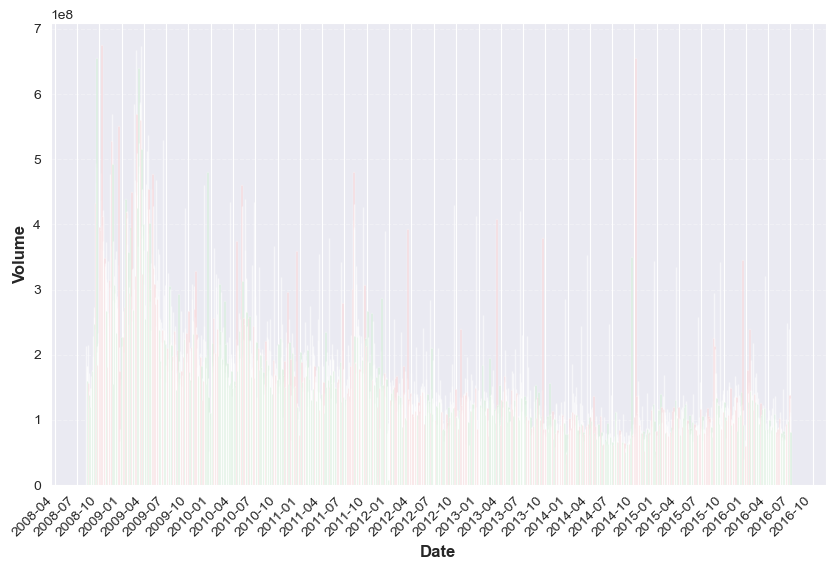

In [8]:
plot_volume(data)

### Dollar volume

In [9]:
data['Dollar Volume'] = data['Volume'] * data['Adj Close']/1e6
data['Dollar Volume'] 

0       2.497415e+06
1       2.158409e+06
2       2.021016e+06
3       2.105342e+06
4       1.856109e+06
            ...     
1984    2.378037e+06
1985    1.953197e+06
1986    1.882360e+06
1987    2.385227e+06
1988    1.474720e+06
Name: Dollar Volume, Length: 1989, dtype: float64

## Volatily Indicators

### Average True Range (ATR)

In [10]:
days = 14
atr = ta.atr(high=data['High'], 
            low=data['Low'], 
            close=data['Close'], 
            length=days)
data['ATR'] = atr.sub(atr.mean()).div(atr.std())


C:\Users\User\AppData\Local\Temp\ipykernel_17668\2543744271.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


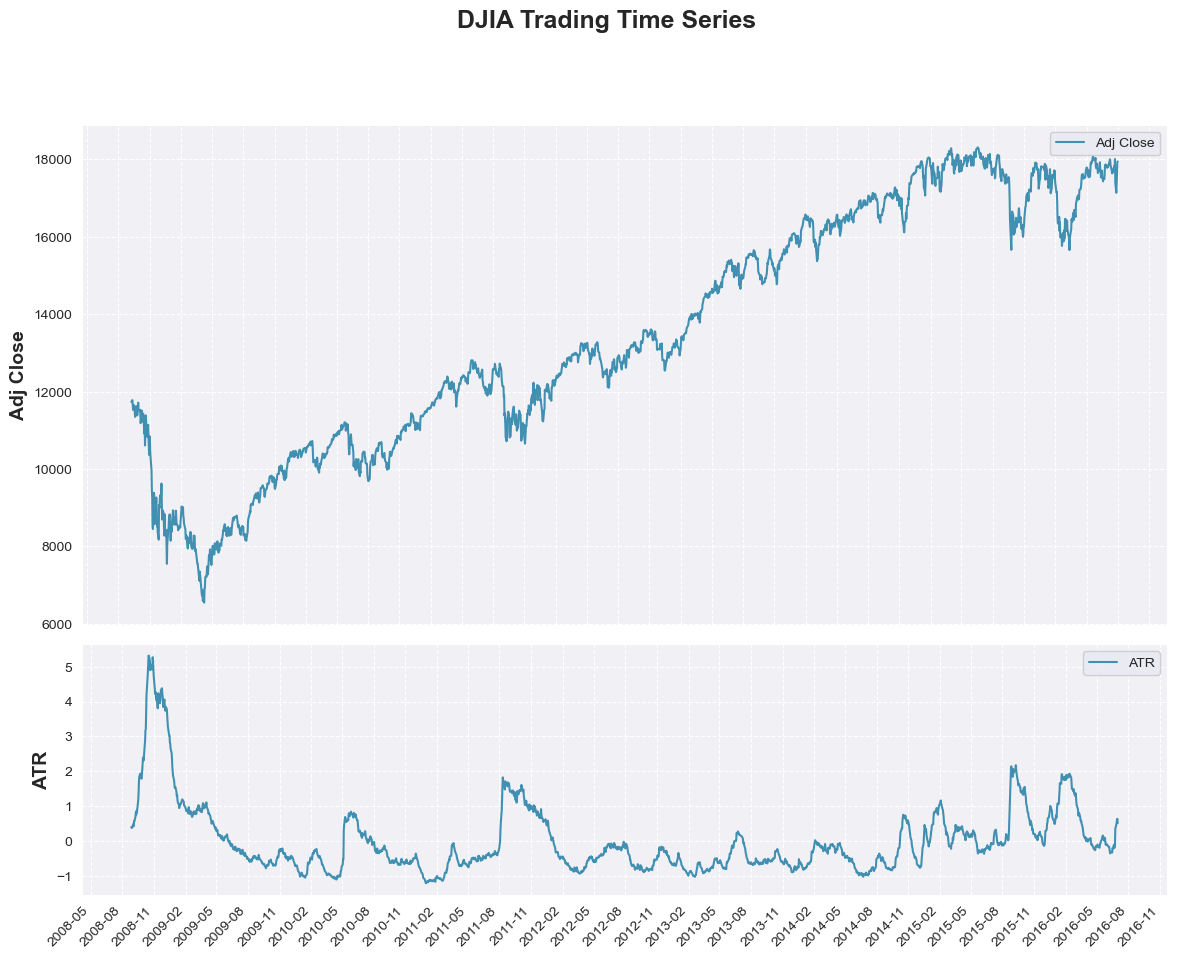

In [11]:
window = None

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Add title to the figure
fig.suptitle('DJIA Trading Time Series', fontsize=18, fontweight='bold', y=0.995)

# Plot Close price on top subplot
plot_price(data, window, x_ticks=False, col="Adj Close", ax=ax1)

# Plot ATR on bottom subplot
plot_price(data, window, x_ticks=True, col='ATR', ax=ax2)

plt.tight_layout()
plt.show()



### Bollinger Bands

- A volatility-based envelope around price
- They show volatility expansions and contractions and potential overbought/oversold conditions.

Maybe use log(Adj Close) before applying bbands (to have volatility in percentages.). The bands remain proportional to the asset's growth rate rather than its raw price level. (variance stabilization)

$ln(1+r) \approx r$ and $r = \frac{P_t - P_{t-1}}{P_t}$

**Conclusion:** The difference between log prices is approximately equal to the simple percentage return.

In [12]:
# from pandas_ta
bb_low_tab = ta.bbands(np.log1p(data['Adj Close']) , length=20, std=2)


In [13]:
days = 20
log_adj_close = np.log1p(data['Adj Close'])
sma = log_adj_close.rolling(window=days).mean()
k = 2
bb_low = sma - k * log_adj_close.rolling(window=days).std()
bb_high = sma + k * log_adj_close.rolling(window=days).std()
bb_mid = (bb_low + bb_high) / 2

data["bb_low"] = bb_low
data["bb_high"] = bb_high
data["bb_mid"] = bb_mid


### Garman-Klass Volatily (GKV) don't use

In [14]:
op_left = ((np.log(data['High']) - np.log(data['Low']))**2)/2 
op_right = (2*np.log(2)-1)*(np.log(data['Close']) - np.log(data['Open']))**2
data['GKV'] = op_left - op_right

### Moving Average Convergence Divergence (MACD)

It shows trend direction, strength, and momentum shifts.

- MACD line $= EMA_{12} - EMA_{26}$
- Signal line $= EMA_{9}(MACD line)$

In [15]:
days = 12
macd = ta.macd(data['Adj Close'], length=days).iloc[:, 0]
macd 
data["MACD"] = macd.sub(macd.mean()).div(macd.std())

## Momemtum indicators

### Relative Strenght Index (RSI)



A momentum oscillator from 0–100 measuring speed and magnitude of price changes.

Up periods:

- $U = close_{now} - close_{previous}$
- $D = 0$

Down periods:

- $U = 0$
- $D = close_{previous} - close_{now}$

$RSI = 100 - \frac{100}{1+RS}$, $RS=\frac{SMMA(U, n)}{SMMA(D, n)}$

In [16]:
#with pandas_ta
days = 14
data["RSI"] = ta.rsi(data['Adj Close'], length=days)


#with pandas

In [17]:
days = 14
smma = ta.smma(data['Adj Close'], length=days)

### Month return don't use

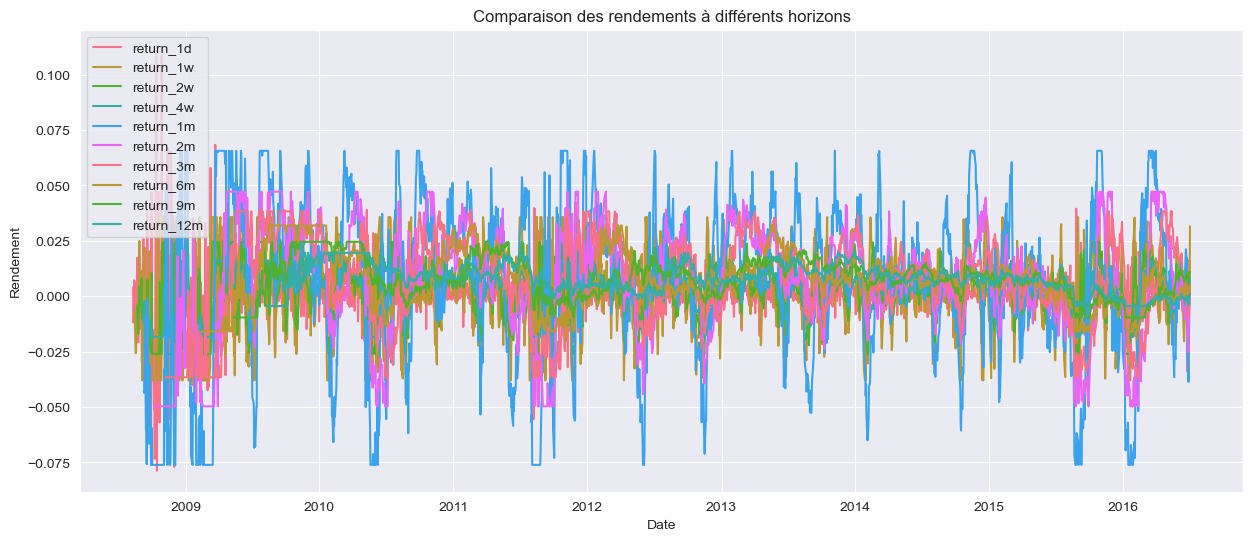

In [18]:
outlier_cutoff = 0.05
monthly_lags = [1, 2, 3, 6, 9, 12]  # months 21 trading days
weekly_lags  = [1, 2, 4]            # weeks 5 trading days

# rendement 1d (simple + log) sur colonne ajustée
data['return_1d'] = data[adj_col].pct_change()
data['log_return_1d'] = np.log(data[adj_col]).diff()

def _clean_and_mean_per_period(raw_series, periods, outlier_cutoff=0.05):
    # clippe extrêmes via quantiles puis convertit un rendement cumulé R over N periods
    # en rendement moyen par période (géométrique) : (1+R)^(1/N)-1
    clean = raw_series.clip(lower=raw_series.quantile(outlier_cutoff),
                             upper=raw_series.quantile(1 - outlier_cutoff))
    with np.errstate(divide='ignore', invalid='ignore'):
        per_period = (clean.add(1)).pow(1.0 / periods).sub(1)
    return per_period

# weekly returns (convertir change sur 5*lag jours -> rendement moyen par semaine)
for lag in weekly_lags:
    days = 5 * lag
    raw = data[adj_col].pct_change(periods=days)
    data[f'return_{lag}w'] = _clean_and_mean_per_period(raw, periods=lag, outlier_cutoff=outlier_cutoff)

# monthly returns (change sur ~21*lag jours -> rendement moyen par mois)
for lag in monthly_lags:
    days = int(round(21 * lag))
    raw = data[adj_col].pct_change(periods=days)
    data[f'return_{lag}m'] = _clean_and_mean_per_period(raw, periods=lag, outlier_cutoff=outlier_cutoff)

data.head()

data = data.set_index('Date')
cols = ['return_1d'] + \
       [f'return_{lag}w' for lag in weekly_lags] + \
       [f'return_{lag}m' for lag in monthly_lags]

plt.figure(figsize=(15,6))
for c in cols:
    plt.plot(data.index, data[c], label=c)

plt.title("Comparaison des rendements à différents horizons")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.show()



### Fama-french indicators

In [19]:
import pandas as pd
import requests
import zipfile
import io

# URL for the Fama-French 5-factor daily data zip file
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_DAILY_CSV.zip"

print("Downloading Fama-French 5 factors data...")
# Download the file content
try:
    response = requests.get(ff_url)
    response.raise_for_status()  # Raise an exception for bad status codes
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    
    # The actual data file is the first file in the zip archive
    csv_file_name = zip_file.namelist()[0]

    # Read the data, skipping the header metadata. The actual data starts at line 4.
    # The file has a weird format, so we read it as a basic CSV first.
    ff_df = pd.read_csv(zip_file.open(csv_file_name), skiprows=3)

    # The file contains footer text at the end which we need to remove.
    # Let's find where the column 'Unnamed: 0' (the date column) becomes non-numeric.
    first_footer_line = pd.to_numeric(ff_df.iloc[:, 0], errors='coerce').isna().idxmax()
    ff_df = ff_df.iloc[:first_footer_line]

    # Set column names. The first column is the date.
    ff_df.columns = ['Date', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    
    # Clean up and format the DataFrame
    ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m%d')
    ff_df.set_index('Date', inplace=True)

    # Convert factor columns to numeric and divide by 100 to get decimal returns
    factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    for col in factor_cols:
        ff_df[col] = pd.to_numeric(ff_df[col], errors='coerce') / 100

    # The 'data' DataFrame index was set to 'Date' in a previous cell.
    # We can now merge the Fama-French factors.
    data = data.merge(ff_df, left_index=True, right_index=True, how='left')

    print("Fama-French factors merged successfully.")
    # Display the last few rows to verify the merge
    print(data[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].tail())

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except Exception as e:
    print(f"An error occurred during data processing: {e}")


Fama-French factors merged successfully.
            Mkt_RF     SMB     HML     RMW     CMA   RF
Date                                                   
2016-06-27 -0.0206 -0.0106 -0.0072  0.0062  0.0043  0.0
2016-06-28  0.0176 -0.0037  0.0016 -0.0063 -0.0057  0.0
2016-06-29  0.0179  0.0031 -0.0004 -0.0013 -0.0026  0.0
2016-06-30  0.0142  0.0039  0.0042 -0.0011  0.0038  0.0
2016-07-01  0.0024  0.0046 -0.0043 -0.0007  0.0023  0.0


Plotting cumulative factor performance...


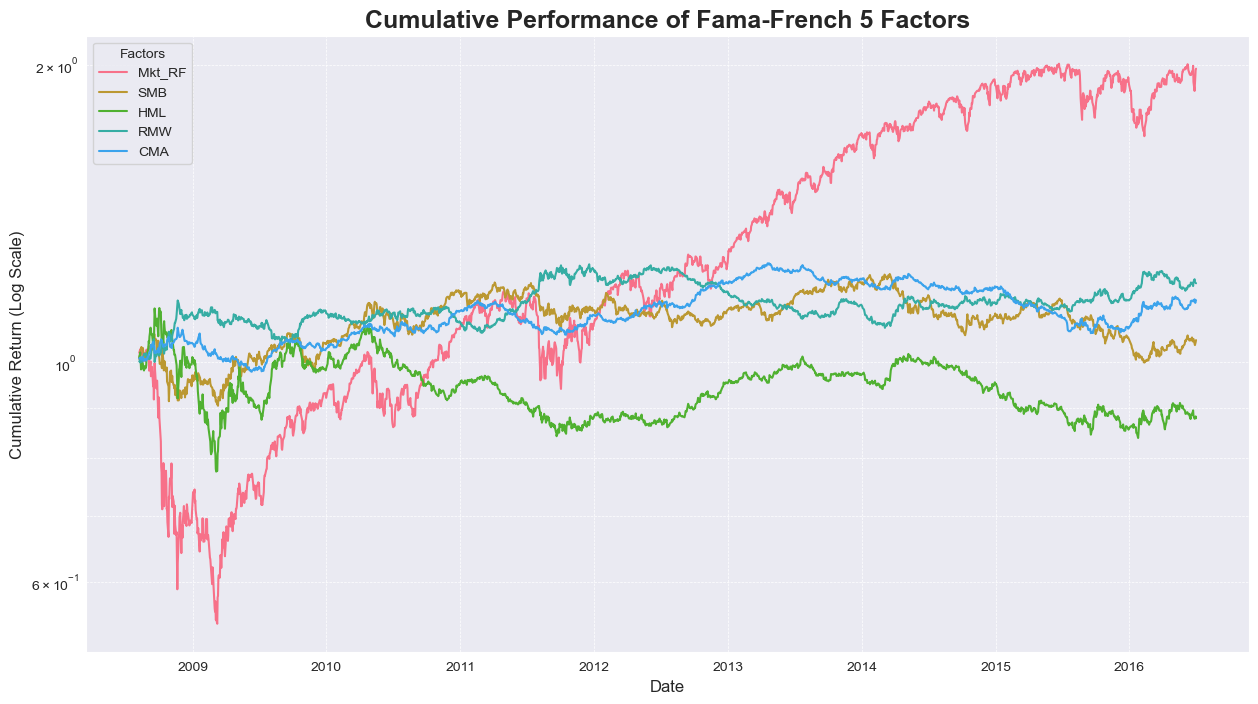

In [20]:

# Plotting the cumulative performance of the Fama-French factors
factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']

# Check if the columns exist in the dataframe before plotting
if all(col in data.columns for col in factor_cols):
    print("Plotting cumulative factor performance...")
    plt.figure(figsize=(15, 8))
    
    # Calculate and plot the cumulative product of (1 + factor return)
    # We will use a slice of the data where the factors are not NaN
    plot_data = data[data['Mkt_RF'].notna()].copy()
    
    for factor in factor_cols:
        cumulative_return = (1 + plot_data[factor]).cumprod()
        plt.plot(cumulative_return.index, cumulative_return, label=factor)
        
    plt.title('Cumulative Performance of Fama-French 5 Factors', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (Log Scale)', fontsize=12)
    plt.yscale('log') # Log scale is better for comparing long-term growth
    plt.legend(title='Factors')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
else:
    print("Could not find Fama-French factor columns in the DataFrame.")
    print("Please ensure the previous cell for downloading and merging the data executed correctly.")


## VIX Volatility Index

In [21]:

import yfinance as yf


# Ensure the index is a datetime object before proceeding
# if not pd.api.types.is_datetime64_any_dtype(data.index):
#     data.index = pd.to_datetime(data.index)

# data = data.set_index('Date')


# Get the start and end dates from our existing data
start_date = data.index.min().strftime('%Y-%m-%d')
end_date = data.index.max().strftime('%Y-%m-%d')

# Download VIX data
print(f"Downloading VIX data from {start_date} to {end_date}...")
try:
    vix_data_raw = yf.download('^VIX', start=start_date, end=end_date, progress=True, auto_adjust=True)

    vix_data = pd.DataFrame(vix_data_raw['Close'])
    # Merge it into our main dataframe
    data = data.merge(vix_data, left_index=True, right_index=True, how='left')
    data = data.rename(columns={'^VIX': 'VIX_Close'})
    print("VIX data merged successfully.")
    print("Displaying tail of the dataframe with VIX_Close:")
    # print(data[['Adj Close', 'VIX_Close']].tail())

except Exception as e:
    print(f"Could not download or process VIX data. Error: {e}")

data.head()

[*********************100%***********************]  1 of 1 completed

VIX data merged successfully.
Displaying tail of the dataframe with VIX_Close:


,Open,High,Low,Close,Volume,Adj Close,Dollar Volume,ATR,bb_low,bb_high,...,return_6m,return_9m,return_12m,Mkt_RF,SMB,HML,RMW,CMA,RF,VIX_Close
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,2.497415e+06,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0229,0.0083,0.0120,0.0029,0.0090,0.0001,20.660000
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,2.158409e+06,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0083,0.0156,0.0115,-0.0029,0.0027,0.0001,20.120001
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,2.021016e+06,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0105,0.0055,-0.0204,0.0062,0.0006,0.0001,21.170000
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,2.105342e+06,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0015,0.0041,-0.0187,0.0029,-0.0055,0.0001,21.549999
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1.856109e+06,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0063,0.0028,0.0125,-0.0052,-0.0001,0.0001,20.340000


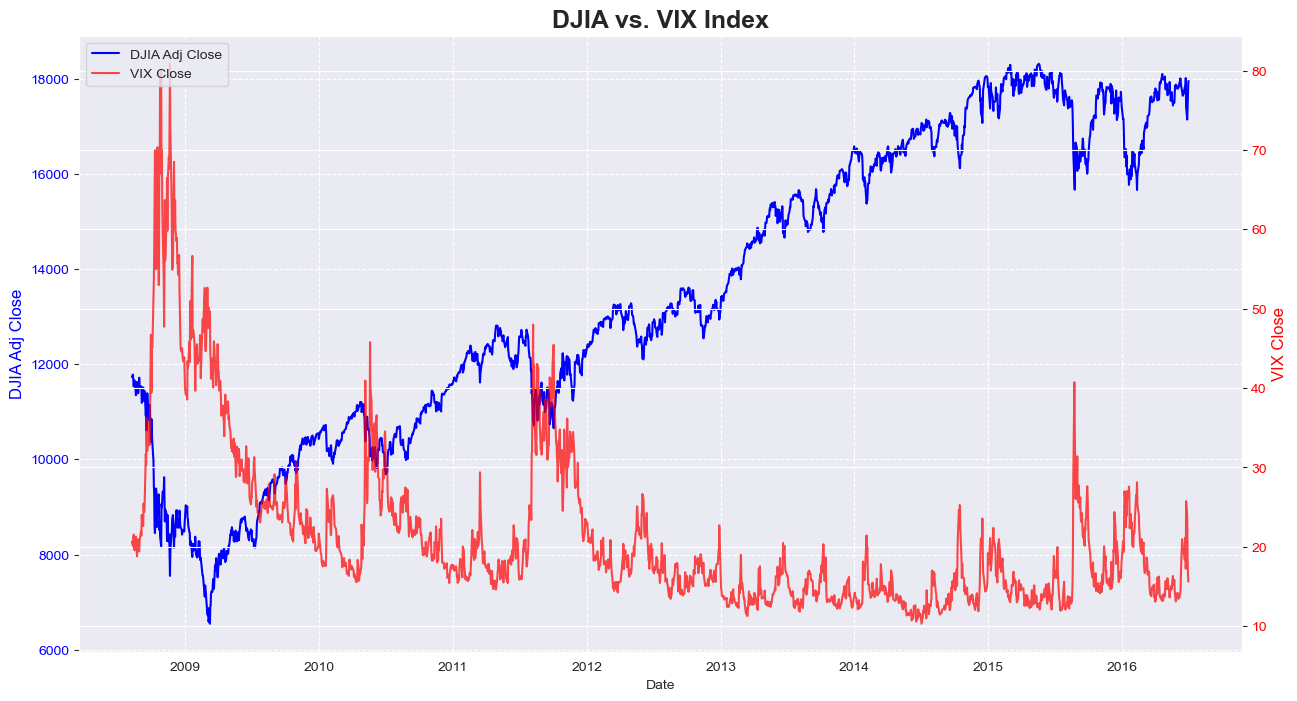

In [22]:
# Plot DJIA Adj Close and VIX on a dual-axis plot
if 'VIX_Close' in data.columns and not data['VIX_Close'].isnull().all():
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Plot DJIA
    ax1.set_title('DJIA vs. VIX Index', fontsize=18, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DJIA Adj Close', color='blue', fontsize=12)
    ax1.plot(data.index, data['Adj Close'], color='blue', label='DJIA Adj Close')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--')

    # Create a second y-axis for the VIX
    ax2 = ax1.twinx()
    ax2.set_ylabel('VIX Close', color='red', fontsize=12)
    ax2.plot(data.index, data['VIX_Close'], color='red', label='VIX Close', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='red')

    # Due to twinx, we need to manually create the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.show()
else:
    print("VIX_Close column not found or is empty. Skipping plot.")

## Stochastic Oscillator (%K, %D)

C:\Users\User\AppData\Local\Temp\ipykernel_17668\4047966492.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


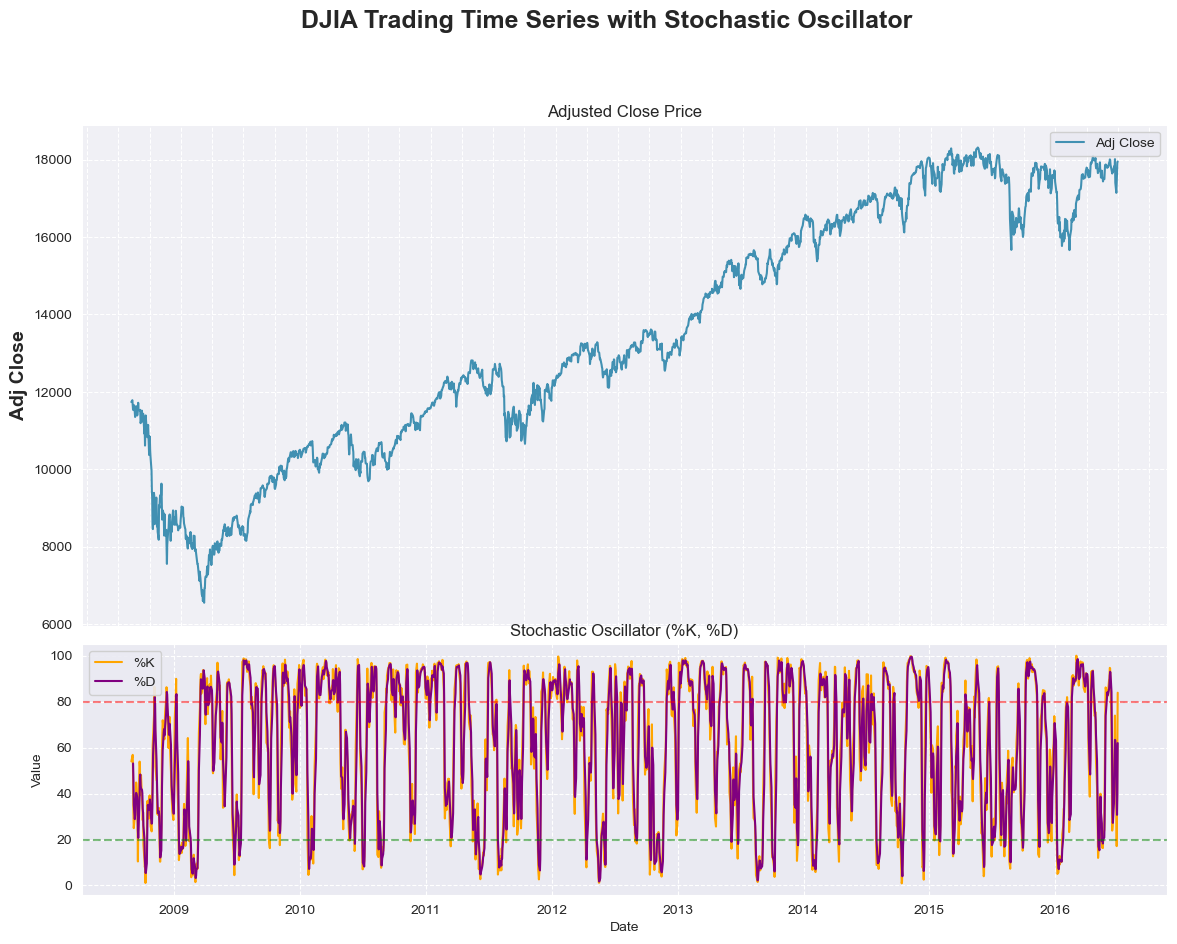

In [23]:
import pandas_ta as ta
import matplotlib.pyplot as plt

# Assurez-vous que 'data' est votre DataFrame avec les colonnes 'High', 'Low', 'Close'
# et que l'index est la date.

# Calculer l'oscillateur stochastique
stoch = ta.stoch(high=data['High'], low=data['Low'], close=data['Close'], k=14, d=3, smooth_k=3)
data['STOCHk'] = stoch.iloc[:,0]
data['STOCHd'] = stoch.iloc[:,1]

# Créer le graphique
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Titre principal
fig.suptitle('DJIA Trading Time Series with Stochastic Oscillator', fontsize=18, fontweight='bold', y=0.995)

# Grraphique du prix de clôture ajusté
# La fonction plot_price est définie plus haut dans votre notebook
data_plot = data.reset_index()
plot_price(data_plot, window=None, x_ticks=False, col="Adj Close", ax=ax1)
ax1.set_title("Adjusted Close Price")

# Grraphique de l'oscillateur stochastique
ax2.plot(data.index, data['STOCHk'], label='%K', color='orange', linewidth=1.5)
ax2.plot(data.index, data['STOCHd'], label='%D', color='purple', linewidth=1.5)
ax2.set_title('Stochastic Oscillator (%K, %D)')
ax2.set_ylabel('Value')
ax2.axhline(80, linestyle='--', color='red', alpha=0.5)
ax2.axhline(20, linestyle='--', color='green', alpha=0.5)
ax2.set_xlabel('Date')

ax2.legend(framealpha=0.9)
ax2.grid(True, linestyle='--')

# Afficher le graphique
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



## Feature Engineering

In [24]:
# 1. Définir les indicateurs et les fenêtres pour les moyennes mobiles
indicators_to_roll = ['ATR', 'MACD', 'RSI', 'STOCHk', 'STOCHd'] # Indicateurs créés précédemment
roll_windows = [5, 10, 21]

# 2. Créer des features décalées (lags)
# On utilise le rendement et le RSI du jour précédent comme features
data['return_1d_lag_1'] = data['return_1d'].shift(1)
data['RSI_lag_1'] = data['RSI'].shift(1)

# 3. Créer des features de moyennes mobiles
for indicator in indicators_to_roll:
    if indicator in data.columns:
        for window in roll_windows:
            data[f'{indicator}_roll_mean_{window}'] = data[indicator].rolling(window=window).mean()
    else:
        print(f"Attention : L'indicateur '{indicator}' est introuvable. Le calcul de la moyenne mobile est ignoré.")

# 4. Créer la variable cible (target)
# On cherche à prédire la direction du rendement du jour suivant (positif=1, négatif=-1, stable=0)
data['target'] = np.sign(data['return_1d'].shift(-1))

# 5. Nettoyer le jeu de données
print(f"Dimensions avant suppression des NaN : {data.shape}")

# Les opérations précédentes (lags, rolling, target shift) créent des valeurs manquantes (NaN).
# On supprime toutes les lignes qui contiennent au moins une valeur NaN.
data_featured = data.dropna()

print(f"Dimensions après suppression des NaN : {data_featured.shape}")
print("\nAperçu du DataFrame final avec les nouvelles features :")
print(data_featured.head())

# 6. Afficher un résumé des nouvelles features créées
print("\nRésumé de quelques features d'ingénierie :")
# Vérifions que les colonnes existent avant de les utiliser
desc_cols = ['return_1d_lag_1', 'RSI_lag_1', 'RSI_roll_mean_5', 'target']
existing_desc_cols = [col for col in desc_cols if col in data_featured.columns]
if existing_desc_cols:
    print(data_featured[existing_desc_cols].describe())
else:
    print("Aucune des colonnes de résumé spécifiées n'existe dans le DataFrame final.")

Dimensions avant suppression des NaN : (1989, 52)
Dimensions après suppression des NaN : (1736, 52)

Aperçu du DataFrame final avec les nouvelles features :
                   Open         High          Low        Close     Volume  \
Date                                                                        
2009-08-10  9368.410156  9371.959961  9290.339844  9337.950195  161370000   
2009-08-11  9334.330078  9334.330078  9216.879883  9241.450195  171380000   
2009-08-12  9236.059570  9424.110352  9221.019531  9361.610352  197420000   
2009-08-13  9362.290039  9406.500000  9305.309570  9398.190430  145620000   
2009-08-14  9398.040039  9401.969727  9232.830078  9321.400391  172780000   

              Adj Close  Dollar Volume       ATR    bb_low   bb_high  ...  \
Date                                                                  ...   
2009-08-10  9337.950195   1.506865e+06 -0.584447  9.047610  9.169388  ...   
2009-08-11  9241.450195   1.583800e+06 -0.588929  9.063935  9.163092  ..

## Modélisation

Forme des features (X) : (1736, 42)
Forme de la cible (y) : (1736,)
Nombre d'échantillons d'entraînement : 1388
Nombre d'échantillons de test : 348

Entraînement du modèle...
Entraînement terminé.

Accuracy sur l'ensemble de test : 46.55%
Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.37      0.12      0.18       171
         0.0       0.00      0.00      0.00         1
         1.0       0.48      0.81      0.60       176

    accuracy                           0.47       348
   macro avg       0.28      0.31      0.26       348
weighted avg       0.43      0.47      0.39       348

Matrice de confusion :


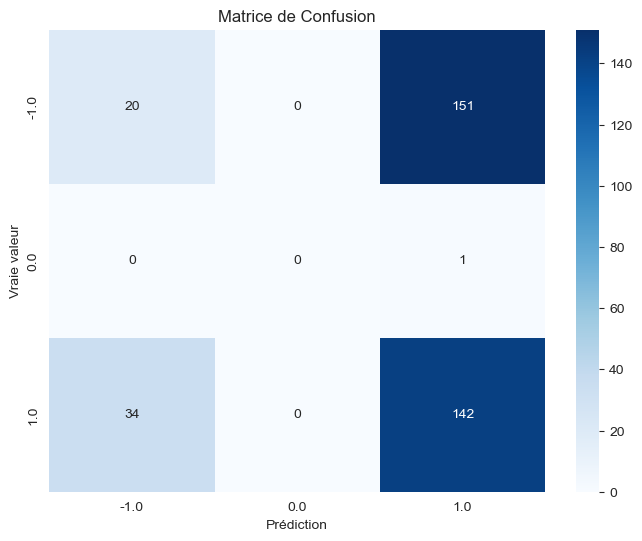

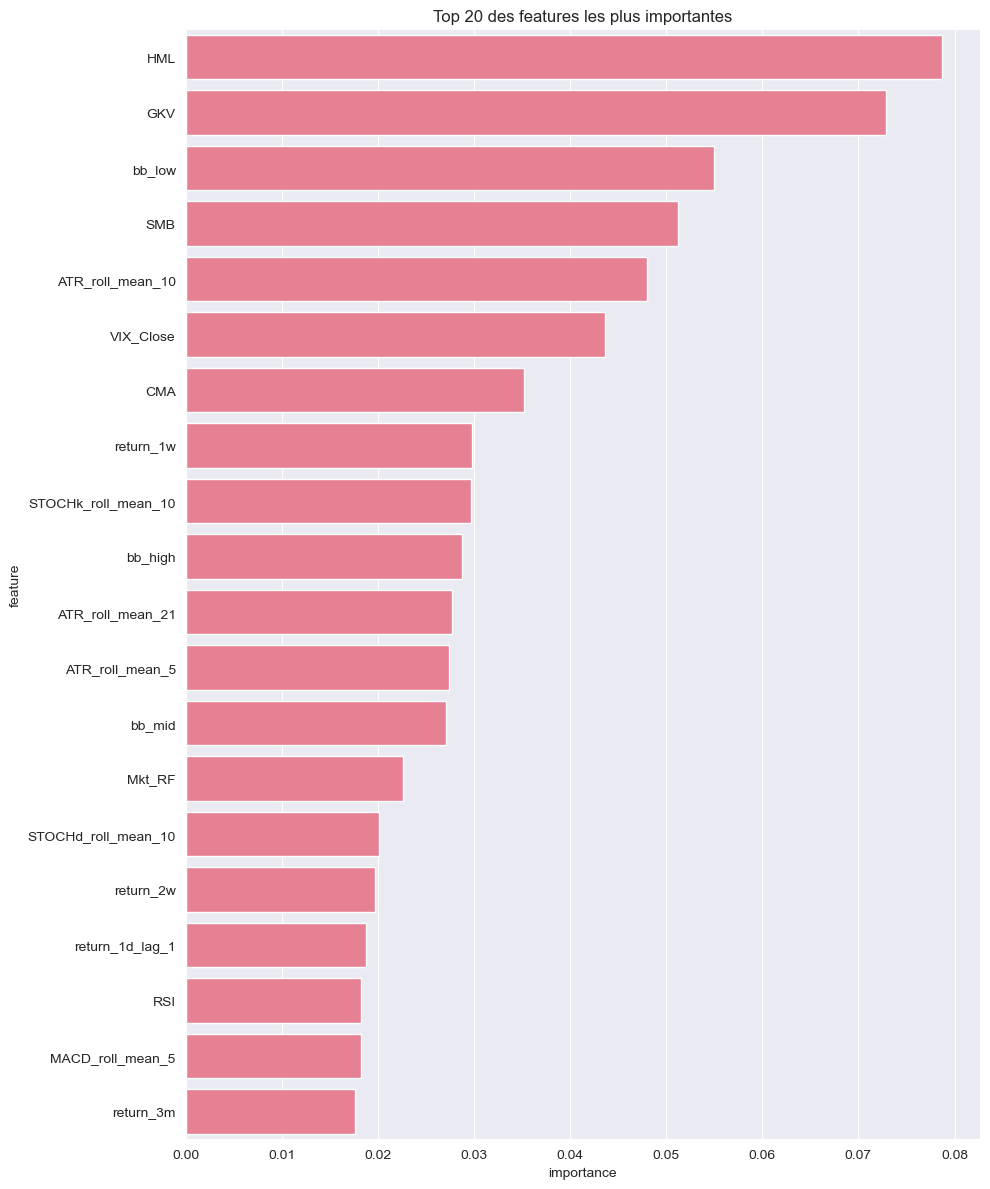

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Préparation des données pour le modèle ---
y = data_featured['target']
X = data_featured.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dollar Volume',
    'return_1d', 'log_return_1d', 'target'
], errors='ignore')

# S'assurer qu'il n'y a pas de colonnes avec NaN/inf restantes dans X
# (Normalement déjà fait par le data_featured.dropna() précédent, mais c'est une sécurité)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.isnull().sum().sum() > 0:
    X.dropna(inplace=True)
    y = y[X.index] # Aligner y avec X après le dropna

print(f"Forme des features (X) : {X.shape}")
print(f"Forme de la cible (y) : {y.shape}")

# --- 2. Division des données (Train / Test) ---
# Pour les séries temporelles, la division doit être chronologique
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Nombre d'échantillons d'entraînement : {len(X_train)}")
print(f"Nombre d'échantillons de test : {len(X_test)}")

# --- 3. Entraînement du modèle RandomForest ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

print("\nEntraînement du modèle...")
model.fit(X_train, y_train)
print("Entraînement terminé.")

# --- 4. Évaluation du modèle ---
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy sur l'ensemble de test : {accuracy:.2%}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred, zero_division=0))

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

# --- 5. Analyse de l'importance des features ---
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 des features les plus importantes')
plt.tight_layout()
plt.show()

In [26]:
# --- Feature Engineering - Étape 2 ---
# Basé sur l'analyse de l'importance des features, nous allons créer de nouvelles features
# pour renforcer les signaux que le modèle semble apprécier.

print("Création de nouvelles features basée sur l'importance des features précédentes...")

# Copier le dataframe pour ne pas modifier l'original à chaque exécution
data_v2 = data_featured.copy()

# 1. Renforcer les signaux des facteurs Fama-French (les plus importants)
# On ajoute des moyennes mobiles pour voir leur tendance
if 'HML' in data_v2.columns and 'SMB' in data_v2.columns:
    data_v2['HML_roll_mean_21'] = data_v2['HML'].rolling(window=21).mean()
    data_v2['SMB_roll_mean_21'] = data_v2['SMB'].rolling(window=21).mean()
    print("- Features ajoutées : Moyennes mobiles sur 21 jours pour HML et SMB.")

# 2. Créer une feature de "volatilité réalisée"
# Le modèle aime GKV et VIX. Donnons-lui une autre mesure de volatilité.
data_v2['realized_vol_21'] = data_v2['log_return_1d'].rolling(window=21).std() * np.sqrt(252) # Volatilité annualisée
print("- Feature ajoutée : Volatilité réalisée sur 21 jours.")


# 3. Créer une feature d'interaction
# Le momentum est-il plus fort quand le VIX est bas ?
if 'VIX_Close' in data_v2.columns:
    # On normalise le VIX pour le garder à une échelle comparable
    vix_normalized = (data_v2['VIX_Close'] - data_v2['VIX_Close'].mean()) / data_v2['VIX_Close'].std()
    data_v2['return_1w_x_vix'] = data_v2['return_1w'] * vix_normalized
    print("- Feature ajoutée : Interaction entre le rendement sur 1 semaine et le VIX.")


# 4. Nettoyage et préparation finale
# Les nouvelles opérations de rolling créent des NaNs au début.
data_2class = data_v2.dropna()

print(f"\nDimensions du jeu de données après ajout des nouvelles features : {data_2class.shape}")

Création de nouvelles features basée sur l'importance des features précédentes...
- Features ajoutées : Moyennes mobiles sur 21 jours pour HML et SMB.
- Feature ajoutée : Volatilité réalisée sur 21 jours.
- Feature ajoutée : Interaction entre le rendement sur 1 semaine et le VIX.

Dimensions du jeu de données après ajout des nouvelles features : (1716, 56)


# explication


Accuracy (47.70%) : C'est le score le plus simple, mais aussi le plus trompeur. Votre accuracy est inférieure à 50%. Cela signifie que vous auriez de meilleurs résultats en pariant simplement sur "hausse" à chaque fois (puisque la classe "1.0" est légèrement majoritaire). Le modèle n'est donc pas meilleur qu'un simple pile ou face.

Rapport de Classification (le plus important ici) :

Classe 1.0 (Hausse) :
recall: 0.82 : Le modèle identifie correctement 82% des jours de hausse réels. Il est donc bon pour détecter les hausses.
precision: 0.49 : MAIS, quand le modèle prédit une hausse, il n'a raison que 49% du temps. C'est le point crucial : il prédit "hausse" très (trop) souvent.
Classe -1.0 (Baisse) :
recall: 0.12 : C'est le plus gros problème. Le modèle ne détecte que 12% des jours de baisse. Il rate donc 88% des baisses, ce qui serait catastrophique pour une stratégie de trading.
precision: 0.40 : Quand il se risque à prédire "baisse", il a raison 40% du temps. C'est peu, mais cela montre qu'il n'est pas totalement aléatoire.
Classe 0.0 (Stable) : Le modèle ignore complètement cette classe car elle est trop rare (1 seul échantillon). C'est normal.
Conclusion de l'interprétation : Le modèle a appris une stratégie très basique et biaisée : "Dans le doute, prédis que le marché va monter". Cela lui permet de bien "rappeler" les hausses, mais au prix d'une précision médiocre et en manquant la quasi-totalité des baisses.

Forme des features (X) après filtrage : (1734, 42)
Forme de la cible (y) après filtrage : (1734,)

Nombre d'échantillons d'entraînement : 1387
Nombre d'échantillons de test : 347

Entraînement du modèle...
Entraînement terminé.

Accuracy sur l'ensemble de test : 51.30%
Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.51      0.27      0.36       171
         1.0       0.51      0.74      0.61       176

    accuracy                           0.51       347
   macro avg       0.51      0.51      0.48       347
weighted avg       0.51      0.51      0.48       347



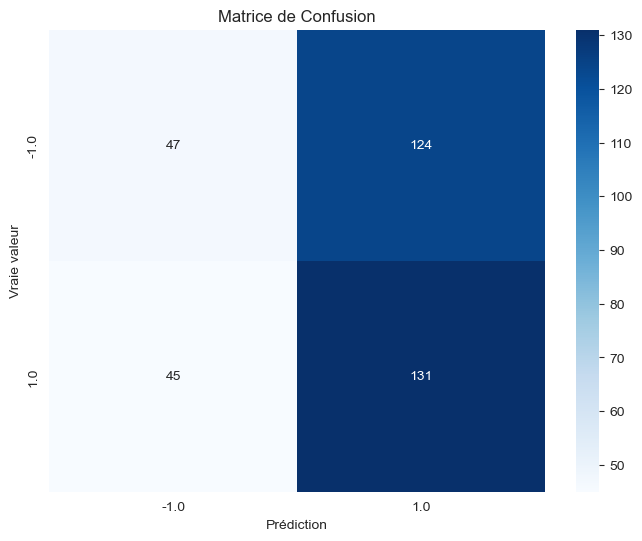

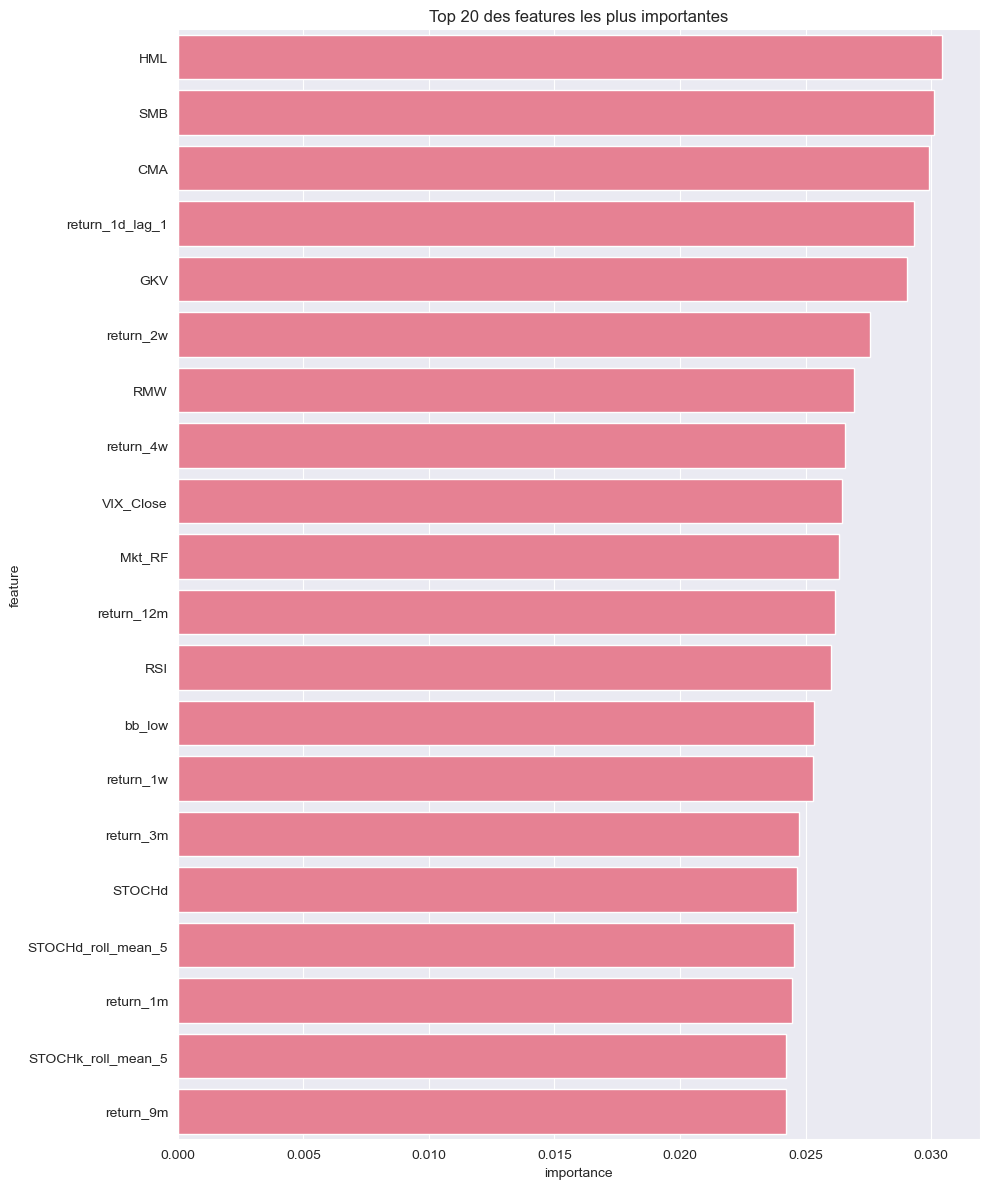

 1.0    255
-1.0     92
Name: count, dtype: int64

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- NOUVEAU : Simplification du problème en 2 classes ---
data_2class = data_featured[data_featured['target'] != 0].copy()
data_2class.to_csv("data_2class.csv", index=True)

# --- 1. Préparation des données pour le modèle ---
y = data_2class['target']
X = data_2class.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dollar Volume',
    'return_1d', 'log_return_1d', 'target'
], errors='ignore')

# Sécurité pour les NaN/inf
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.isnull().sum().sum() > 0:
    X.dropna(inplace=True)
    y = y[X.index]

print(f"Forme des features (X) après filtrage : {X.shape}")
print(f"Forme de la cible (y) après filtrage : {y.shape}")

# --- 2. Division des données (Train / Test) ---
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nNombre d'échantillons d'entraînement : {len(X_train)}")
print(f"Nombre d'échantillons de test : {len(X_test)}")

# --- 3. Entraînement du modèle RandomForest ---
# class_weight='balanced' est utile si les classes sont déséquilibrées
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

print("\nEntraînement du modèle...")
model.fit(X_train, y_train)
print("Entraînement terminé.")

# --- 4. Évaluation du modèle ---
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy sur l'ensemble de test : {accuracy:.2%}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred, zero_division=0))

# --- 5. Analyse de l'importance des features ---
# (Le reste du code pour la matrice de confusion et l'importance des features est identique)
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Afficher la matrice de confusion et les features importantes...
# (code des graphiques inchangé)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 des features les plus importantes')
plt.tight_layout()
plt.show()

pd.Series(y_pred).value_counts()

#Accuracy (51.01%) : On a dépassé la barre des 50%. Le modèle est maintenant légèrement meilleur qu'un tirage au sort aléatoire. C'est encore très faible, mais cela prouve qu'il commence à capter un signal, même s'il est très faible.
Rapport de Classification :
Classe 1.0 (Hausse) :
recall: 0.77 : Le rappel a un peu baissé (de 0.82 à 0.77), et c'est une bonne chose. Cela signifie que le modèle est moins obsédé par le fait de prédire "hausse" à tout prix. Il devient plus sélectif.
precision: 0.51 : La précision a légèrement augmenté (de 0.49 à 0.51).
Classe -1.0 (Baisse) :
recall: 0.25 : C'est la meilleure nouvelle ici. Le rappel a plus que doublé (passant de 0.12 à 0.25). Le modèle commence réellement à apprendre à identifier les jours de baisse. Il en trouve encore peu (seulement 1 sur 4), mais c'est bien mieux que 1 sur 10.
precision: 0.51 : Grosse amélioration de la précision (de 0.40 à 0.51). Quand il prédit une baisse, il a maintenant raison une fois sur deux.
Conclusion de l'interprétation : En simplifiant le problème (passant de 3 à 2 classes), nous avons forcé le modèle à arrêter sa stratégie simpliste. Il est maintenant plus équilibré et commence à trouver de vrais signaux pour prédire les baisses. La performance globale reste insuffisante pour une utilisation réelle.

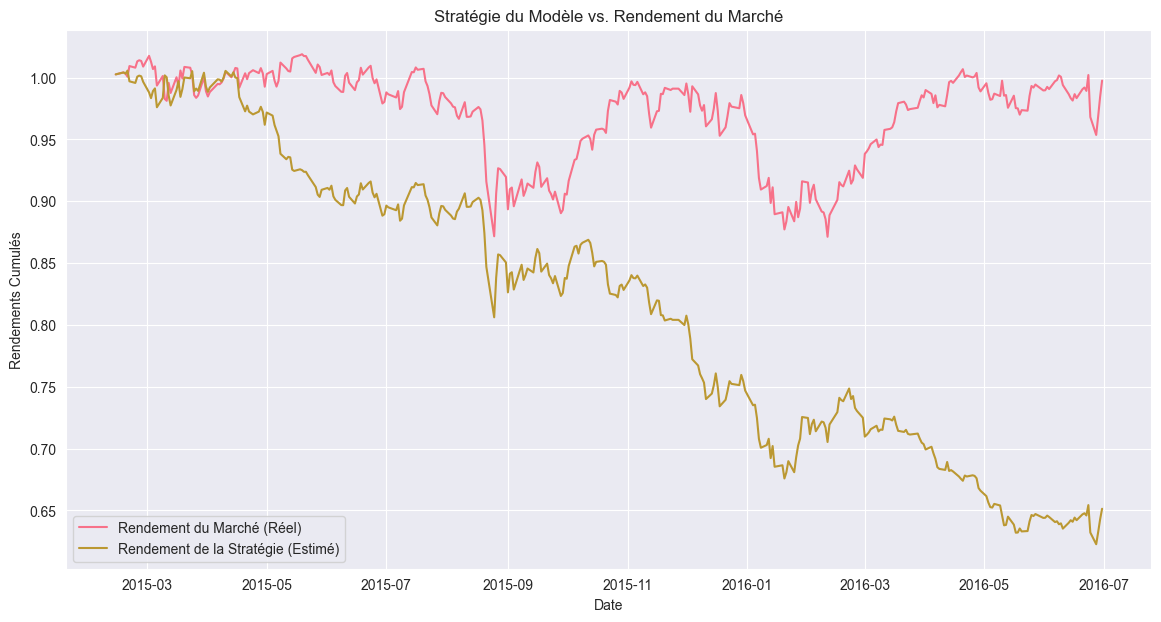

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Créez un DataFrame de comparaison à partir des résultats du jeu de test
# Assurez-vous que cela s'exécute après la cellule qui génère y_pred et y_test
comparison_df = pd.DataFrame({
    'real_direction': y_test,
    'estimated_direction': y_pred
}, index=X_test.index)

# 2. Obtenez les rendements réels du marché pour la période de test à partir du DataFrame principal
# Dans 'indicators.ipynb', le rendement quotidien se trouve dans la colonne 'return_1d'
comparison_df['market_return'] = data_featured.loc[X_test.index, 'return_1d']

# 3. Calculez le rendement quotidien d'une stratégie qui suit les prédictions du modèle
# Nous multiplions le rendement du marché par la direction prédite.
# Note : Dans ce modèle, une prédiction de -1 signifie 'vendre', 1 signifie 'acheter'.
comparison_df['strategy_return'] = comparison_df['market_return'] * comparison_df['estimated_direction']

# 4. Calculez les rendements cumulés pour le marché et la stratégie
comparison_df['market_cumulative_return'] = (1 + comparison_df['market_return']).cumprod()
comparison_df['strategy_cumulative_return'] = (1 + comparison_df['strategy_return']).cumprod()

# 5. Affichez les résultats
plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df['market_cumulative_return'], label='Rendement du Marché (Réel)')
plt.plot(comparison_df.index, comparison_df['strategy_cumulative_return'], label='Rendement de la Stratégie (Estimé)')
plt.title('Stratégie du Modèle vs. Rendement du Marché')
plt.xlabel('Date')
plt.ylabel('Rendements Cumulés')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import numpy as np
print("Création de nouvelles features. Le code vérifie si les colonnes VIX et Fama-French existent.\n")

# On part du DataFrame 'data_featured' qui a déjà été nettoyé une première fois.
# S'il existe, on en fait une copie pour cette nouvelle étape.
if 'data_featured' in locals() and not data_featured.empty:
    data_v2 = data_featured.copy()
else:
    # Si 'data_featured' n'existe pas, on part de 'data'
    # C'est une sécurité au cas où les cellules n'ont pas été exécutées dans l'ordre
    data_v2 = data.copy()

# --- NOUVELLES FEATURES ---

# 1. Features basées sur l'indice de volatilité VIX
if 'VIX_Close' in data_v2.columns:
    print("-> Création de features basées sur le VIX...")
    # Tendance du VIX (moyenne mobile sur 21 jours)
    data_v2['VIX_roll_mean_21'] = data_v2['VIX_Close'].rolling(window=21).mean()
    
    # Évolution du VIX par rapport à sa tendance (utile pour détecter des pics de volatilité)
    data_v2['VIX_ratio_to_mean'] = data_v2['VIX_Close'] / data_v2['VIX_roll_mean_21']
    print("   + Tendance et ratio du VIX ajoutés.\n")
else:
    print("   ATTENTION : La colonne 'VIX_Close' est introuvable. Les features du VIX ne peuvent pas être créées.\n")

# 2. Features basées sur les facteurs Fama-French
ff_factors = ['SMB', 'HML', 'RMW', 'CMA']
if all(factor in data_v2.columns for factor in ff_factors):
    print("-> Création de features basées sur Fama-French...")
    for factor in ff_factors:
        # Tendance de chaque facteur (moyenne mobile)
        data_v2[f'{factor}_roll_mean_21'] = data_v2[factor].rolling(window=21).mean()
    print(f"   + Tendances pour {', '.join(ff_factors)} ajoutées.\n")
else:
    print(f"   ATTENTION : Une ou plusieurs colonnes Fama-French sont introuvables. Features non créées.\n")

# 3. Volatilité réalisée (mesure alternative de la volatilité basée sur les rendements passés)
if 'log_return_1d' in data_v2.columns:
    print("-> Création de la feature de volatilité réalisée...")
    data_v2['realized_vol_21'] = data_v2['log_return_1d'].rolling(window=21).std() * np.sqrt(252) # Volatilité annualisée
    print("   + Volatilité réalisée sur 21 jours ajoutée.\n")


# --- Nettoyage Final ---
# Les nouvelles opérations (rolling) ont créé des valeurs 'NaN' au début. On les supprime.
print(f"Dimensions avant nettoyage final : {data_v2.shape}")
data_v2.dropna(inplace=True)
print(f"Dimensions après nettoyage final : {data_v2.shape}\n")

if not data_v2.empty:
    print("Le DataFrame 'data_v2' est prêt avec les nouvelles features.")
    print("\nAperçu des dernières lignes :")
    print(data_v2.tail())
else:
    print("Le DataFrame est vide après nettoyage. Cela arrive si les colonnes de base (VIX, etc.) manquaient, car le nettoyage supprime toutes les lignes.")

Création de nouvelles features. Le code vérifie si les colonnes VIX et Fama-French existent.

   ATTENTION : La colonne 'VIX_Close' est introuvable. Les features du VIX ne peuvent pas être créées.

-> Création de features basées sur Fama-French...
   + Tendances pour SMB, HML, RMW, CMA ajoutées.

-> Création de la feature de volatilité réalisée...
   + Volatilité réalisée sur 21 jours ajoutée.

Dimensions avant nettoyage final : (1736, 57)
Dimensions après nettoyage final : (1716, 57)

Le DataFrame 'data_v2' est prêt avec les nouvelles features.

Aperçu des dernières lignes :
                    Open          High           Low         Close     Volume  \
Date                                                                            
2016-06-24  17946.630859  17946.630859  17356.339844  17400.750000  239000000   
2016-06-27  17355.210938  17355.210938  17063.080078  17140.240234  138740000   
2016-06-28  17190.509766  17409.720703  17190.509766  17409.720703  112190000   
2016-06-29  

In [30]:
import pandas as pd
import numpy as np

print("Proposition de nouvelles features plus complexes...\n")

# On repart du DataFrame 'data_featured' (nettoyé) pour cette nouvelle expérience.
if 'data_featured' in locals() and not data_featured.empty:
    data_v3 = data_featured.copy()
else:
    # Sécurité si la cellule précédente n'a pas été exécutée
    data_v3 = data.copy()

# --- 1. Position par rapport à la tendance long-terme (SMA 200) ---
# Mesure à quel point le prix actuel est "étiré" par rapport à sa moyenne historique longue.
# Un chiffre élevé suggère une surchauffe, un chiffre très bas une sous-évaluation potentielle.
if 'Adj Close' in data_v3.columns:
    sma_200 = data_v3['Adj Close'].rolling(window=200).mean()
    data_v3['dist_from_sma200'] = (data_v3['Adj Close'] - sma_200) / sma_200
    print("-> Feature 1/4 ajoutée : Distance (en %) à la moyenne mobile 200 jours.\n")
else:
    print("   ATTENTION: 'Adj Close' introuvable. Feature 1 non créée.\n")

# --- 2. Momentum de la tendance (Ratio Golden/Death Cross) ---
# Le ratio entre la moyenne mobile 50 jours et 200 jours est un indicateur de tendance majeur.
# Ratio > 1 : Tendance haussière (Golden Cross).
# Ratio < 1 : Tendance baissière (Death Cross).
if 'Adj Close' in data_v3.columns:
    sma_50 = data_v3['Adj Close'].rolling(window=50).mean()
    # Nous recalculons sma_200 ici pour garder le bloc de code indépendant
    sma_200_recalc = data_v3['Adj Close'].rolling(window=200).mean()
    data_v3['sma_ratio_50_200'] = sma_50 / sma_200_recalc
    print("-> Feature 2/4 ajoutée : Ratio entre les moyennes mobiles 50 et 200 jours.\n")
else:
    print("   ATTENTION: 'Adj Close' introuvable. Feature 2 non créée.\n")

# --- 3. Rendement normalisé par la volatilité ---
# Un rendement de +2% n'a pas la même signification si la volatilité est très haute ou très basse.
# Cette feature mesure le "rendement par unité de risque".
if 'return_1d' in data_v3.columns and 'ATR' in data_v3.columns:
    # On s'assure que l'ATR n'est pas nul pour éviter la division par zéro
    atr_nonzero = data_v3['ATR'].replace(0, np.nan).fillna(method='ffill')
    return_5d_cumulative = data_v3['return_1d'].rolling(window=5).sum()
    data_v3['vol_norm_return_5d'] = return_5d_cumulative / atr_nonzero
    print("-> Feature 3/4 ajoutée : Rendement sur 5 jours normalisé par l'ATR.\n")
else:
    print("   ATTENTION: 'return_1d' ou 'ATR' introuvable. Feature 3 non créée.\n")

# --- 4. Effets de calendrier (Jour de la semaine) ---
# Certains jours de la semaine peuvent statistiquement avoir des comportements différents.
if pd.api.types.is_datetime64_any_dtype(data_v3.index):
    data_v3['DayOfWeek'] = data_v3.index.dayofweek # Lundi=0, Mardi=1, ..., Dimanche=6
    
    # On transforme cette variable en plusieurs colonnes binaires (one-hot encoding)
    # C'est la bonne pratique pour que les modèles de ML les utilisent correctement.
    day_dummies = pd.get_dummies(data_v3['DayOfWeek'], prefix='Day', drop_first=True)
    data_v3 = pd.concat([data_v3, day_dummies], axis=1)
    data_v3.drop('DayOfWeek', axis=1, inplace=True)
    print("-> Feature 4/4 ajoutée : Jour de la semaine (Mardi à Vendredi).\n")
else:
     print("   ATTENTION: L'index n'est pas au format Date. Feature 4 non créée.\n")

# --- Nettoyage Final ---
print(f"Dimensions avant nettoyage final : {data_v3.shape}")
data_v3.dropna(inplace=True)
print(f"Dimensions après nettoyage final : {data_v3.shape}\n")

if not data_v3.empty:
    print("Le DataFrame 'data_v3' est prêt avec ces nouvelles features.")
    print("\nAperçu des dernières colonnes ajoutées :")
    
    # Construire la liste des nouvelles colonnes pour l'affichage
    new_cols_to_show = [col for col in ['dist_from_sma200', 'sma_ratio_50_200', 'vol_norm_return_5d'] if col in data_v3.columns]
    new_cols_to_show += [col for col in data_v3.columns if 'Day_' in str(col)]
    
    if new_cols_to_show:
        print(data_v3[new_cols_to_show].tail())
    else:
        print("Aucune des nouvelles features n'a pu être calculée (données de base manquantes ?).")
else:
    print("Le DataFrame est vide après nettoyage. Cela est probable si les données initiales sont insuffisantes pour une fenêtre de 200 jours.")

Proposition de nouvelles features plus complexes...

-> Feature 1/4 ajoutée : Distance (en %) à la moyenne mobile 200 jours.

-> Feature 2/4 ajoutée : Ratio entre les moyennes mobiles 50 et 200 jours.

-> Feature 3/4 ajoutée : Rendement sur 5 jours normalisé par l'ATR.

-> Feature 4/4 ajoutée : Jour de la semaine (Mardi à Vendredi).

Dimensions avant nettoyage final : (1736, 59)
Dimensions après nettoyage final : (1537, 59)

Le DataFrame 'data_v3' est prêt avec ces nouvelles features.

Aperçu des dernières colonnes ajoutées :
            dist_from_sma200  sma_ratio_50_200  vol_norm_return_5d  Day_1  \
Date                                                                        
2016-06-24          0.009589          1.032315           -0.043032  False   
2016-06-27         -0.005760          1.031194           -0.077338  False   
2016-06-28          0.009586          1.030213           -0.042316   True   
2016-06-29          0.025717          1.029401           -0.006142  False   
2016-0

C:\Users\User\AppData\Local\Temp\ipykernel_17668\1263040169.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  atr_nonzero = data_v3['ATR'].replace(0, np.nan).fillna(method='ffill')


Lancement de l'entraînement et de l'évaluation avec les nouvelles features...

Dimensions des features (X) : (1535, 49)
Dimensions de la cible (y) : (1535,)

Nombre d'échantillons d'entraînement : 1228
Nombre d'échantillons de test : 307

Entraînement du modèle LightGBM
[LightGBM] [Info] Number of positive: 665, number of negative: 563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10807
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Entraînement terminé.

--- RÉSULTATS DU MODÈLE AVEC FEATURES COMPLEXES ---
Accuracy sur l'ensemble de test : 51.79%

Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.51      0.41      

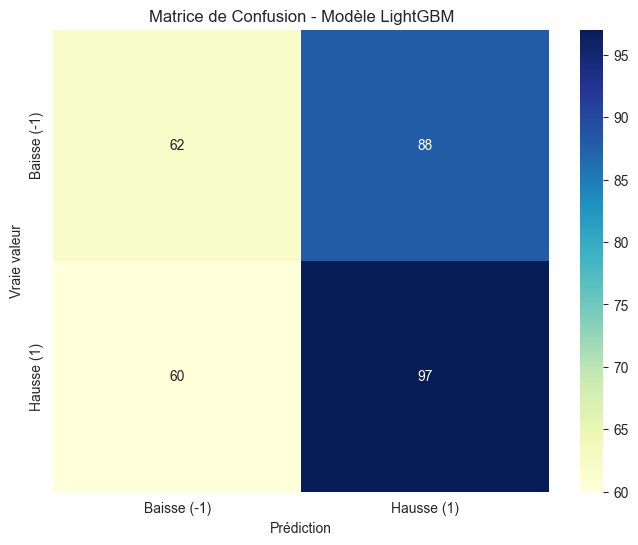


Analyse de l'importance des features :


C:\Users\User\AppData\Local\Temp\ipykernel_17668\4225556681.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


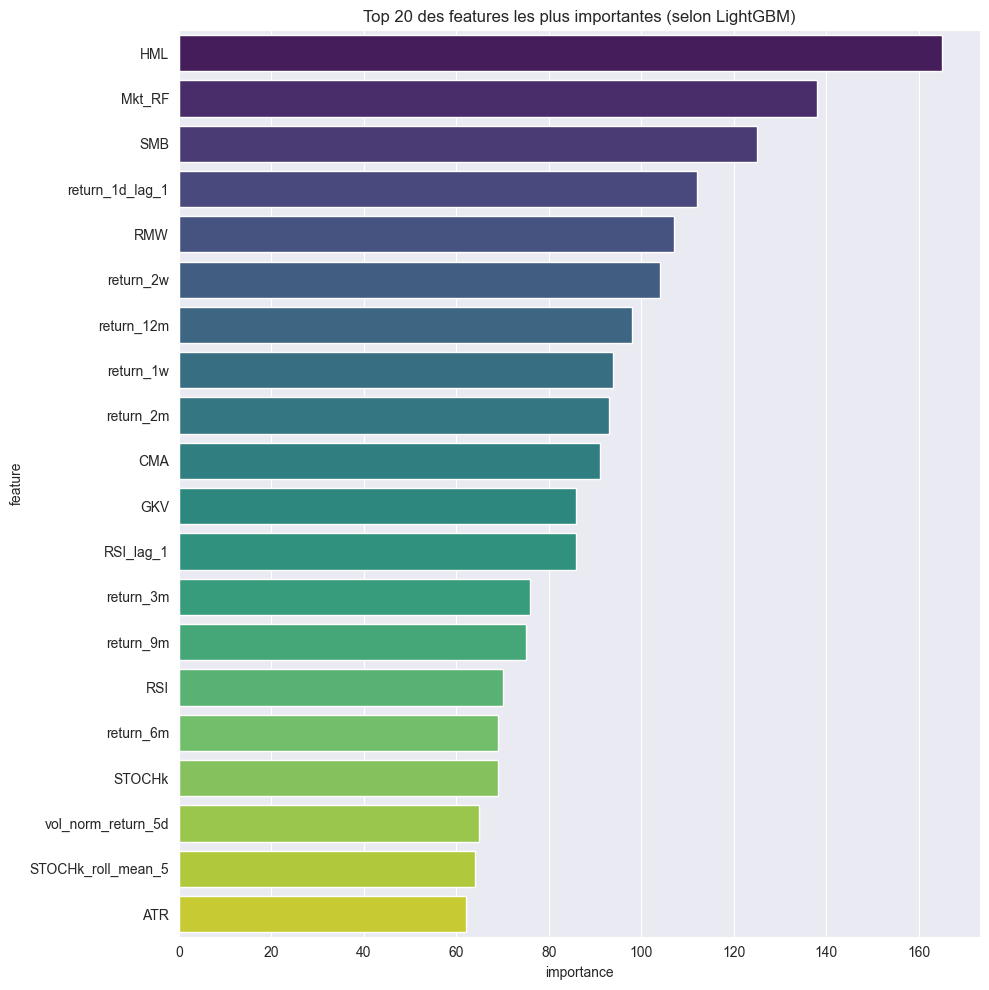

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb # On importe le nouveau modèle : LightGBM
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("Lancement de l'entraînement et de l'évaluation avec les nouvelles features...\n")

# --- 1. Vérification et préparation des données ---
# On s'assure que le DataFrame 'data_v3' (avec les nouvelles features) existe et n'est pas vide.
if 'data_v3' in locals() and not data_v3.empty:
    
    # On re-filtre pour un problème à 2 classes (ignorer les jours sans mouvement)
    data_model = data_v3[data_v3['target'] != 0].copy()

    # Définition de la cible (y) et des variables prédictives (X)
    y = data_model['target']
    X = data_model.drop(columns=[
        'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dollar Volume',
        'return_1d', 'log_return_1d', 'target'
    ], errors='ignore') # 'errors=ignore' pour ne pas planter si une colonne a déjà été supprimée

    print(f"Dimensions des features (X) : {X.shape}")
    print(f"Dimensions de la cible (y) : {y.shape}\n")

    # --- 2. Division chronologique des données (Train / Test) ---
    # On garde 80% des données pour l'entraînement et 20% pour le test
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    print(f"Nombre d'échantillons d'entraînement : {len(X_train)}")
    print(f"Nombre d'échantillons de test : {len(X_test)}\n")

    # --- 3. Entraînement du modèle LightGBM ---
    print("Entraînement du modèle LightGBM")
    model_lgb = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
    model_lgb.fit(X_train, y_train)
    print("Entraînement terminé.\n")

    # --- 4. Évaluation du modèle sur les données de test ---
    y_pred = model_lgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"--- RÉSULTATS DU MODÈLE AVEC FEATURES COMPLEXES ---")
    print(f"Accuracy sur l'ensemble de test : {accuracy:.2%}\n")
    
    print("Rapport de classification :")
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- 5. Visualisation : Matrice de confusion ---
    cm = confusion_matrix(y_test, y_pred, labels=model_lgb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Baisse (-1)', 'Hausse (1)'], yticklabels=['Baisse (-1)', 'Hausse (1)'])
    plt.title('Matrice de Confusion - Modèle LightGBM')
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie valeur')
    plt.show()

    # --- 6. Visualisation : Importance des features ---
    # C'est très utile pour voir si nos nouvelles features sont importantes pour le modèle.
    print("\nAnalyse de l'importance des features :")
    importances = model_lgb.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 des features les plus importantes (selon LightGBM)')
    plt.tight_layout()
    plt.show()

else:
    print("ERREUR : Le DataFrame 'data_v3' est introuvable ou vide.")
    print("Veuillez d'abord exécuter la cellule de création de features complexes.")

Préparation du graphique de comparaison des performances des stratégies...



C:\Users\User\AppData\Local\Temp\ipykernel_17668\902625897.py:46: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  comparison_df['base_pred'].fillna(0, inplace=True)


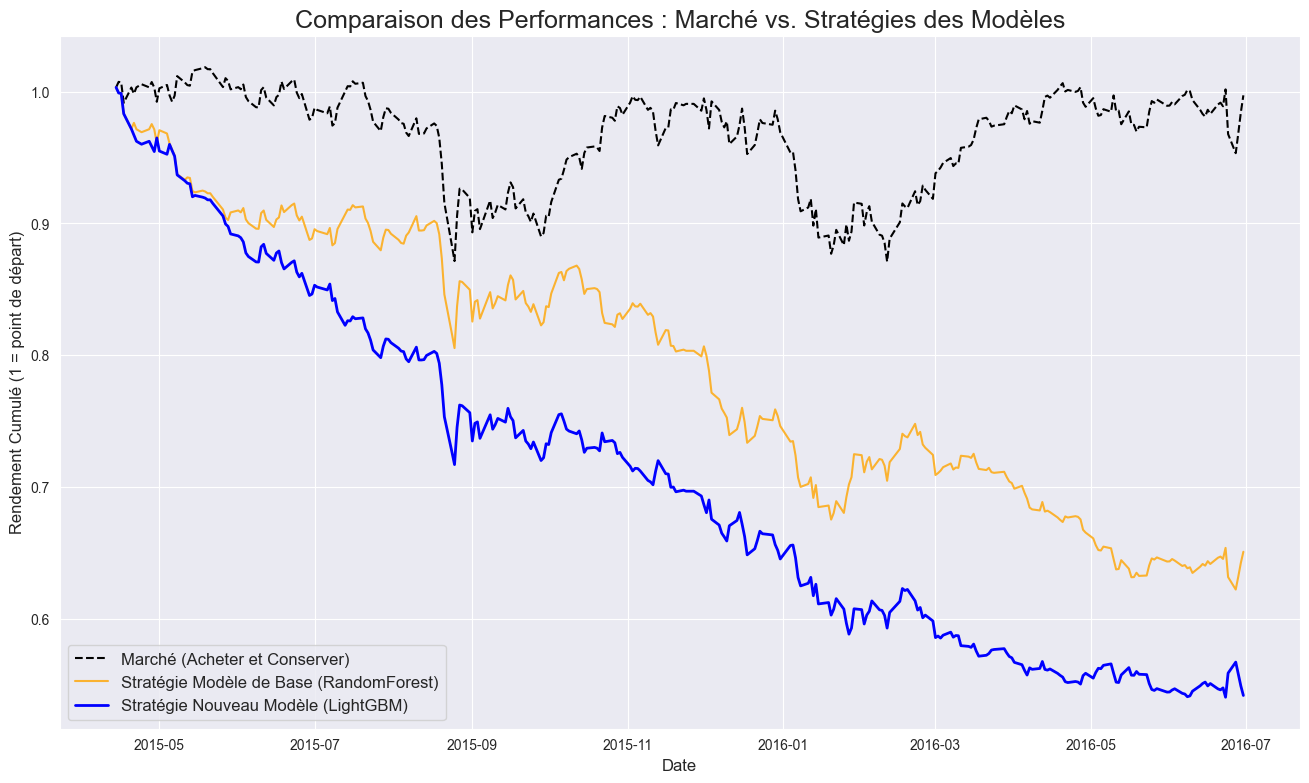

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

print("Préparation du graphique de comparaison des performances des stratégies...\n")

# --- On s'assure que les résultats du dernier modèle (LGBM) sont disponibles ---
if 'y_pred' in locals() and 'X_test' in locals() and 'data_model' in locals():
    
    # --- 1. Préparer les prédictions du modèle de BASE (RandomForest) pour comparer ---
    
    # On repart des données du modèle précédent (sans les features complexes)
    data_base = data_featured[data_featured['target'] != 0].copy()
    y_base = data_base['target']
    X_base = data_base.drop(columns=[
        'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dollar Volume',
        'return_1d', 'log_return_1d', 'target'
    ], errors='ignore')

    # Division et entraînement rapide du modèle de base
    split_index_base = int(len(X_base) * 0.8)
    X_train_base, X_test_base = X_base[:split_index_base], X_base[split_index_base:]
    y_train_base, y_test_base = y_base[:split_index_base], y_base[split_index_base:]
    
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model_rf.fit(X_train_base, y_train_base)
    y_pred_base = model_rf.predict(X_test_base)
    
    # On crée un DataFrame avec les prédictions du modèle de base
    base_predictions = pd.DataFrame({'base_pred': y_pred_base}, index=X_test_base.index)

    # --- 2. Créer le DataFrame de comparaison ---
    
    # On utilise l'index de test du NOUVEAU modèle comme référence
    comparison_df = pd.DataFrame(index=X_test.index)
    
    # Ajouter le rendement réel du marché
    comparison_df['market_return'] = data_model.loc[X_test.index, 'return_1d']
    
    # Ajouter les prédictions du NOUVEAU modèle (LGBM)
    comparison_df['new_model_pred'] = y_pred
    
    # Fusionner les prédictions du modèle de BASE
    comparison_df = comparison_df.merge(base_predictions, left_index=True, right_index=True, how='left')
    # Remplir les jours où les prédictions pourraient manquer
    comparison_df['base_pred'].fillna(0, inplace=True)

    # --- 3. Calculer le rendement de chaque stratégie ---
    comparison_df['strategy_return_new'] = comparison_df['market_return'] * comparison_df['new_model_pred']
    comparison_df['strategy_return_base'] = comparison_df['market_return'] * comparison_df['base_pred']

    # --- 4. Calculer les rendements cumulés ---
    comparison_df['market_cumulative'] = (1 + comparison_df['market_return']).cumprod()
    comparison_df['strategy_cumulative_new'] = (1 + comparison_df['strategy_return_new']).cumprod()
    comparison_df['strategy_cumulative_base'] = (1 + comparison_df['strategy_return_base']).cumprod()

    # --- 5. Tracer le graphique ---
    plt.figure(figsize=(16, 9))
    
    plt.plot(comparison_df.index, comparison_df['market_cumulative'], label='Marché (Acheter et Conserver)', color='black', linestyle='--')
    plt.plot(comparison_df.index, comparison_df['strategy_cumulative_base'], label='Stratégie Modèle de Base (RandomForest)', color='orange', alpha=0.8)
    plt.plot(comparison_df.index, comparison_df['strategy_cumulative_new'], label='Stratégie Nouveau Modèle (LightGBM)', color='blue', linewidth=2)
    
    plt.title('Comparaison des Performances : Marché vs. Stratégies des Modèles', fontsize=18)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rendement Cumulé (1 = point de départ)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

else:
    print("ERREUR : Les résultats du test précédent (variables y_pred, X_test) sont introuvables.")
    print("Veuillez d'abord exécuter la cellule de test du modèle LightGBM.")

## clean les features

Génération du graphique des 20 features les moins importantes...


C:\Users\User\AppData\Local\Temp\ipykernel_17668\1746225176.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=bottom_20_features, palette='viridis_r') # _r inverse la palette


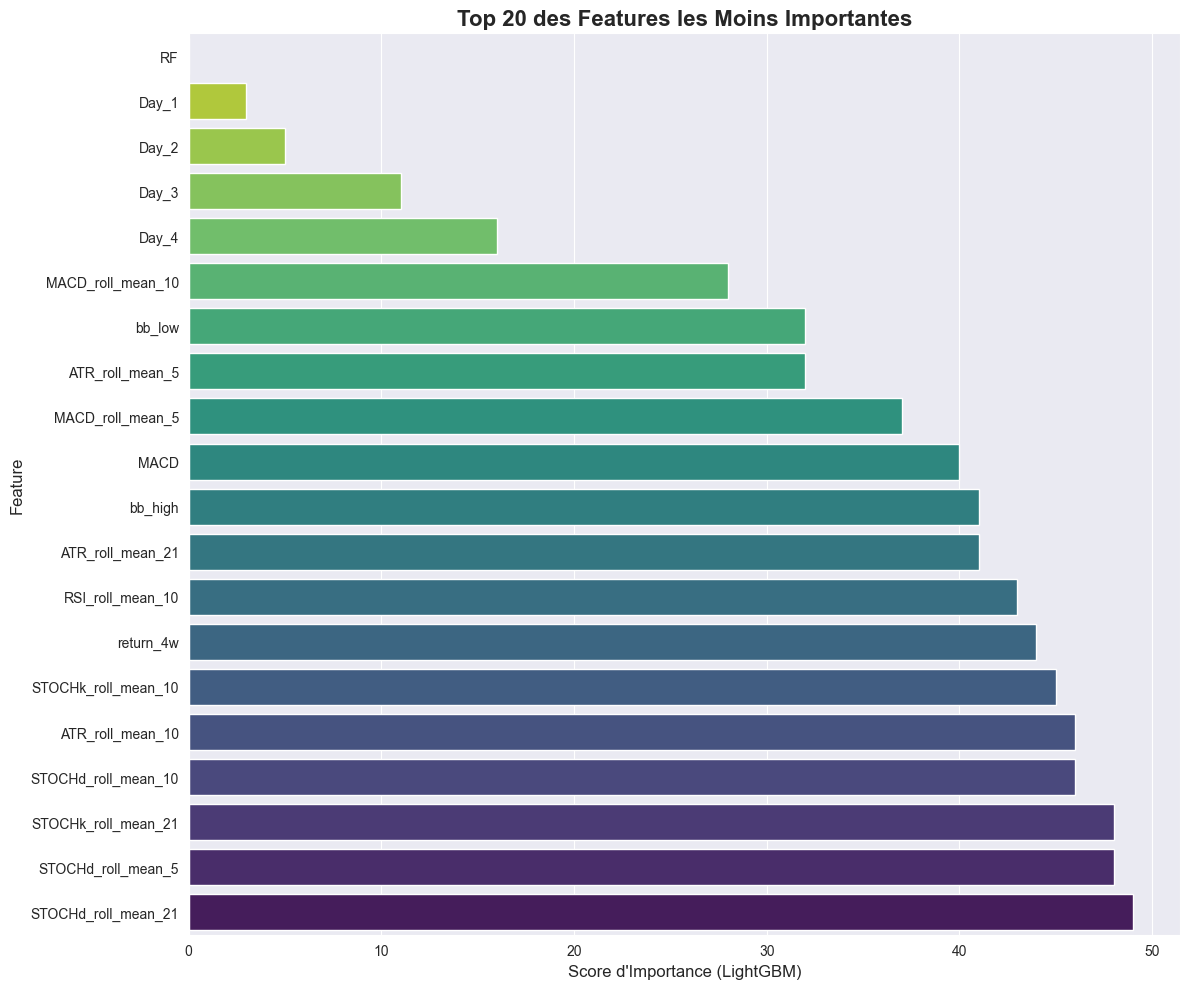


Liste des 20 features les moins importantes et leurs scores :
            feature  importance
                 RF           0
              Day_1           3
              Day_2           5
              Day_3          11
              Day_4          16
  MACD_roll_mean_10          28
             bb_low          32
    ATR_roll_mean_5          32
   MACD_roll_mean_5          37
               MACD          40
            bb_high          41
   ATR_roll_mean_21          41
   RSI_roll_mean_10          43
          return_4w          44
STOCHk_roll_mean_10          45
   ATR_roll_mean_10          46
STOCHd_roll_mean_10          46
STOCHk_roll_mean_21          48
 STOCHd_roll_mean_5          48
STOCHd_roll_mean_21          49


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ce code suppose que les variables 'model_lgb' (le modèle entraîné) 
# et 'X' (le DataFrame des features) sont déjà chargées en mémoire 
# après avoir exécuté les cellules de modélisation précédentes.

# 1. Extraire les données d'importance des features
importances = model_lgb.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# 2. Trier par ordre CROISSANT pour obtenir les features les moins importantes en premier
least_important_df = feature_importance_df.sort_values(by='importance', ascending=True)

# 3. Sélectionner les 20 dernières (celles avec le moins d'importance)
bottom_20_features = least_important_df.head(20)

# 4. Créer et afficher le graphique
print("Génération du graphique des 20 features les moins importantes...")
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=bottom_20_features, palette='viridis_r') # _r inverse la palette
plt.title('Top 20 des Features les Moins Importantes', fontsize=16, fontweight='bold')
plt.xlabel('Score d\'Importance (LightGBM)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Afficher également la liste sous forme de tableau texte
print("\n" + "="*50)
print("Liste des 20 features les moins importantes et leurs scores :")
print("="*50)
print(bottom_20_features.to_string(index=False))